In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
np.set_printoptions(precision=3, linewidth=140)

In [2]:
def curve(x): 
    return 2*x.sin() + 1.0

In [3]:
X = torch.linspace(-4, 4, 100)[...,None]
GT = curve(X)
X.shape, GT.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

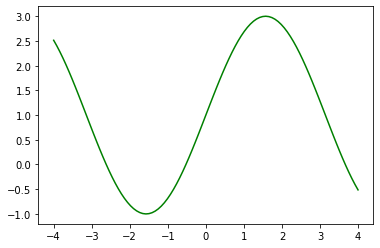

In [4]:
fig, ax = plt.subplots()
ax.plot(X, GT, color='green', label='GT');

In [5]:
def draw_figure(x, W, b, pred, gt, relu=True, title='NonLinearity', frames=None):
    xmin, xmax, gtmin, gtmax = x.min(), x.max(), gt.min(), gt.max()
    y = x @ W.t() + b
    if relu: 
        y = y.clamp_min(0.)
    fig, ax = plt.subplots(dpi=300)
    ax.plot(x, gt, label='GT', color='g')
    for i in range(y.shape[1]):
        ax.plot(x, y[:,i].detach().numpy(), linestyle=':', linewidth=0.75)
    ax.plot(x, pred.detach().numpy(), label='Pred', color='b', linestyle='--')
    padx, pady = (xmax-xmin)*0.05, (gtmax-gtmin)*0.05
    ax.set_ylim(gtmin-pady, gtmax+pady)
    ax.set_xlim(xmin-padx, xmax+padx)
    ax.set_title(title)
    ax.legend()
    if frames is not None:
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
        plt.close(fig)

In [6]:
class Linear(nn.Module):
    def __init__(self, n_in=1, n_out=3, relu=False):
        super().__init__()
        self.linear = nn.Linear(n_in, n_out)
        if relu: self.activation = nn.ReLU()
        else: self.activation = nn.Identity()
        self.wsum = nn.Linear(n_out, 1)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        x = self.wsum(x)
        return x

In [7]:
torch.manual_seed(100)
num_units = 10
use_relu = True
epochs = 10000
display_every = 500
lr = 0.5
bs = 100

In [8]:
model = Linear(n_in=1, n_out=num_units, relu=use_relu)

In [9]:
frames_for_animation = []
for epoch in range(epochs):
    if epoch % display_every == 0:
        with torch.no_grad(): 
            pred = model(X)
            loss = F.mse_loss(pred, GT)
        draw_figure(X, model.linear.weight, model.linear.bias, pred, GT, relu=use_relu, 
            title=f'#units:{num_units}  epoch:{epoch:04d}: loss: {loss:06.4f}', frames=frames_for_animation)
    for i in range(0, X.shape[0], bs):
        slc = slice(i, min(i+bs, X.shape[0]))
        x = X[slc]
        gt = GT[slc]
        pred = model(x)
        loss = F.mse_loss(pred.sum(1, keepdim=True), gt)
        loss.backward()
        with torch.no_grad():
            model.linear.weight -= lr * model.linear.weight.grad
            model.linear.bias -= lr * model.linear.bias.grad
            model.linear.weight.grad.zero_()
            model.linear.bias.grad.zero_()
with torch.no_grad(): 
    pred = model(X)
    loss = F.mse_loss(pred, GT)
draw_figure(X, model.linear.weight, model.linear.bias, pred, GT, relu=use_relu,
    title=f'#units:{num_units}  epoch:{epoch:04d}: loss: {loss:06.4f}', frames=frames_for_animation)

In [10]:
def update_frame(i, frames, ax):
    ax.clear()
    ax.imshow(frames[i])
    ax.axis('off')

fig, ax = plt.subplots(dpi=80)
fig.set_tight_layout(True)
ani = FuncAnimation(fig, update_frame, frames=len(frames_for_animation), interval=250, repeat=False, fargs=(frames_for_animation,ax))
plt.close()
HTML(ani.to_jshtml())

In [11]:
prefix = f'20240503_relu_outdir/relu_curvefitting_{num_units:02d}'
ani.save(f'{prefix}.mp4', writer='ffmpeg', fps=10, dpi=300)
!ffmpeg -i {prefix}.mp4 -vf "fps=20,scale=800:-1:flags=lanczos" -c:v pam -y -hide_banner -loglevel error -f image2pipe - | convert -delay 10 -loop 0 - {prefix}.gif